## Preliminary Predictive Analytics Modeling

In [ ]:
#importing libraries necessary for preliminary predictive analytics model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

#importing initial csv file containing the data
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_450_FinalProject/Processed_FinalProject_Data.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Linear Regression Model/Baseline

Assumptions
*   Linearity: The dependent and independent variables should have a linear relationship, assessed via scatterplots.
* Multivariate Normality: Residuals should be normally distributed, checked using histograms, Q-Q plots, or statistical tests (e.g., Kolmogorov-Smirnov test).
* No Multicollinearity:
Independent variables should not be highly correlated.
Check correlation matrices (coefficients < 0.80) and Variance Inflation Factor (VIF < 10).
* Homoscedasticity:
Residual variance should be consistent across all levels of independent variables.
Patterns like a cone shape indicate heteroscedasticity, which may require data transformation or model adjustments.





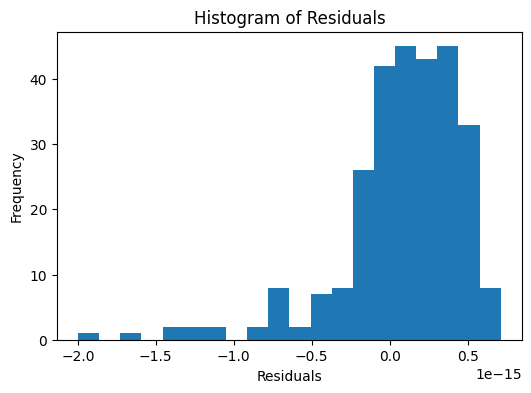

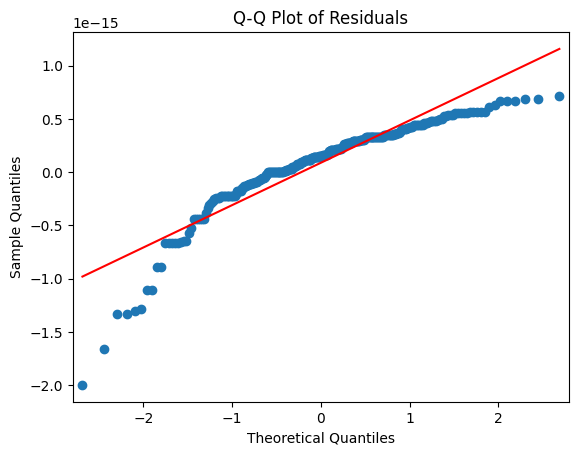

Kolmogorov-Smirnov test: statistic=0.49999999999999967, p-value=1.4656206167803036e-64


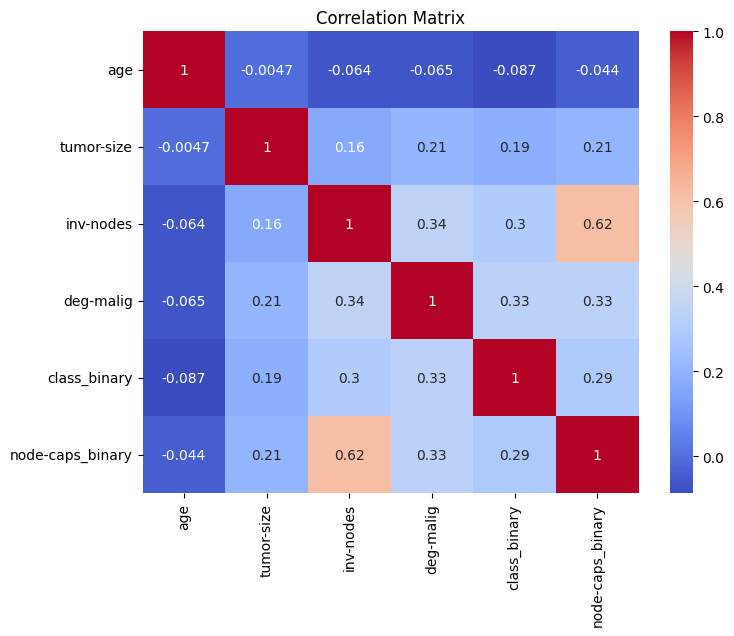

            feature       VIF
0               age  8.908938
1        tumor-size  7.008483
2         inv-nodes  2.607154
3         deg-malig  9.295852
4      class_binary  1.699600
5  node-caps_binary  2.103074


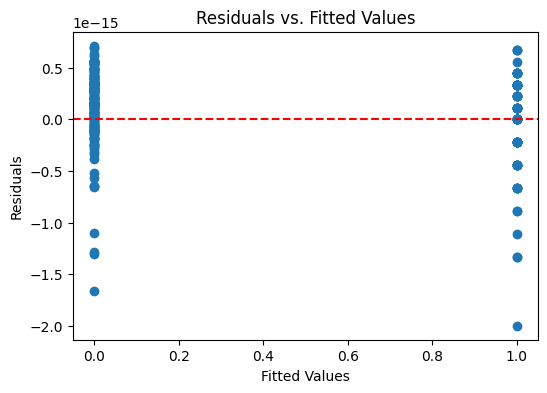

In [ ]:
# --- Assumption Checks ---
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'df' is your DataFrame containing the data
X = df.select_dtypes(include=['number'])  # Select only numerical features for X
y = df['class_binary']  # Target variable

# Multivariate Normality
# Histogram and Q-Q plot of residuals
# Fit an OLS model to get residuals
X_with_const = sm.add_constant(X)  # Add constant for intercept
model_ols = sm.OLS(y, X_with_const).fit()
residuals = model_ols.resid

# Histogram of residuals
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=20)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot of residuals
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Kolmogorov-Smirnov test for normality
from scipy.stats import kstest
ks_statistic, p_value = kstest(residuals, 'norm')
print(f"Kolmogorov-Smirnov test: statistic={ks_statistic}, p-value={p_value}")

# No Multicollinearity
# Correlation matrix
correlation_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Homoscedasticity
# Residuals vs. Fitted values plot
plt.figure(figsize=(6, 4))
plt.scatter(model_ols.fittedvalues, residuals)
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at 0
plt.show()

Observations:
* assumptions have been satisfied for linear regression as confirmed by the visualizations and statistics above

Linear Regression Using All Variables

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# Separate features (X) and target (y)
X = df.drop('class_binary', axis=1)  # Features: all columns except 'class_binary'
y = df['class_binary']  # Target: 'class_binary'

# Create a OneHotEncoder object
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse=False for dense output

# Fit the encoder on the categorical features and transform them
categorical_features = X.select_dtypes(include=['object']).columns # Select categorical columns
encoded_features = encoder.fit_transform(X[categorical_features])

# Create a DataFrame from the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Drop the original categorical features and concatenate the encoded features
X = X.drop(categorical_features, axis=1)
X = pd.concat([X, encoded_df], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust test_size and random_state as needed

# Create a Linear Regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.18735643821250988
R-squared: 0.0007656628666139476


Linear Regression Using Only Numerical Variables

In [ ]:
# Separate features (X) and target (y)
X = df.select_dtypes(include=['number'])  # Select only numerical features
y = df['class_binary']  # Target: 'class_binary'

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust test_size and random_state as needed

# Create a Linear Regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 5.110049302325527e-31
R-squared: 1.0


Linear Regression Function Finding Optimal Test_Size and Random_State

In [ ]:
X = df.select_dtypes(include=['number'])  # Select only numerical features
y = df['class_binary']  # Target: 'class_binary'

# Define ranges for test_size and random_state
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]  # Example test sizes
random_states = range(1, 51)  # Example random states from 1 to 50

best_score = -1  # Initialize with a low value
best_params = {}  # Store the best parameters

# Iterate through test_size and random_state values
for test_size in test_sizes:
    for random_state in random_states:
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        # Create and train model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Evaluate model using cross-validation
        scores = cross_val_score(model, X, y, cv=5, scoring='r2')
        avg_score = scores.mean()

        # Update best score and parameters if current score is better
        if avg_score > best_score:
            best_score = avg_score
            best_params = {'test_size': test_size, 'random_state': random_state}

# Print the best parameters and score
print(f"Best parameters: {best_params}")
print(f"Best average R-squared: {best_score}")

# Train the final model using the best parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_params['test_size'], random_state=best_params['random_state'])
final_model = LinearRegression()
final_model.fit(X_train, y_train)

Best parameters: {'test_size': 0.1, 'random_state': 1}
Best average R-squared: 1.0


LinearRegression()

Observations (Linear Regression):
* when all variables are included, the R^2 drops drastically to ~0.00077, meaning the predictors collectively explain almost none of the variance in the target
* This could be a result of multicollinearity (high correlation between predictors), which makes it hard for the model to identify strong relationships
* Some important variables in the 3-variable model lose their predictive power when combined with others (interactions, nonlinear effects)


#### XGBoost


Assumptions:
* XGBoost may assume that encoded integer values for each input variable have an ordinal relationship
* XGBoost assume that your data may not be complete (i.e. it can deal with missing values)
* Categorical variables must be transformed into numeric variables because XGBoost only manages numeric vectors

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 0.7239393939393939
Accuracy: 0.8035714285714286
Precision: 0.7142857142857143
Recall: 0.35714285714285715
F1 Score: 0.4761904761904762


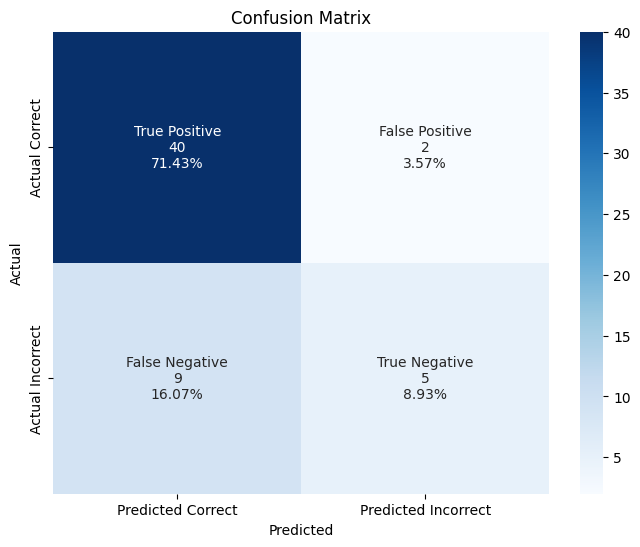

In [ ]:
#install xgboost
!pip install xgboost==1.7.5
!pip install scikit-learn==1.3.0 # Downgrade scikit-learn

#import necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score # Import precision, recall, f1
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt # Import matplotlib for plotting
import seaborn as sns # Import seaborn for heatmap

#seperate features (x) and target (y)
X = df.drop('class_binary', axis=1)
y = df['class_binary']

# Convert object type columns to numerical using Label Encoding
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    scoring='accuracy',  # Use appropriate scoring metric
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
    verbose=2  # Print progress during grid search
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the model with the best parameters
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', **best_params)
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test set using the XGBoost model
# Change 'model' to 'best_xgb_model' for prediction
y_pred = best_xgb_model.predict(X_test)
y_pred_binary = [round(value) for value in y_pred] # Convert probabilities to binary predictions (0 or 1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Using matplotlib and seaborn for better visualization
plt.figure(figsize=(8, 6))
group_names = ['True Positive','False Positive','False Negative','True Negative']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues",
            xticklabels=['Predicted Correct','Predicted Incorrect'],
            yticklabels=['Actual Correct', 'Actual Incorrect'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

XGBoost (w/ SMOTE)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:33:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6964285714285714
Precision: 0.38461538461538464
Recall: 0.35714285714285715
F1 Score: 0.3703703703703704


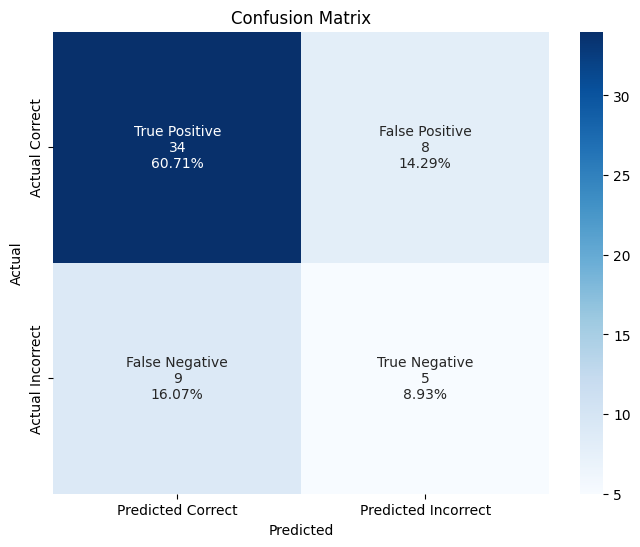

In [ ]:
!pip install scikit-learn==1.3.2

import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Assuming 'df' is your DataFrame
X = df.drop('class_binary', axis=1)
y = df['class_binary']

# Convert object type columns to numerical using Label Encoding
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters (you might need to tune these)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    # Add other parameters as needed
}

# Train the XGBoost model
xgb_model = xgb.train(params, dtrain)

# Make predictions on the test set
y_pred = xgb_model.predict(dtest)
y_pred_binary = [round(value) for value in y_pred]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Using matplotlib and seaborn for better visualization
plt.figure(figsize=(8, 6))
group_names = ['True Positive','False Positive','False Negative','True Negative']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues",
            xticklabels=['Predicted Correct','Predicted Incorrect'],
            yticklabels=['Actual Correct', 'Actual Incorrect'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Observations (XGBoost):
* SMOTE did not yield any visible improvements to model performance
* Accuracy (0.80 or 80.4%)
The model correctly classifies 80.4% of all instances in the dataset.
However, accuracy alone can be misleading, especially since the dataset is imbalanced (the no cancer recurrence appears much more than the other).
* Precision (0.714 or 71.4%)
Precision = TP / (TP + FP) (true positives divided by all predicted positives). 71.4% precision means that when the model predicts the positive class, it is correct 71.4% of the time.
A relatively low precision suggests many false positives (incorrectly classifying negatives as positives).
* Recall (0.357 or 35.7%)
Recall = TP / (TP + FN) (true positives divided by all actual positives). 35.7% recall means the model only identifies 35.7% of actual positive cases, missing a significant portion.
A low recall indicates the model has many false negatives (failing to detect positives).
* F1 Score (0.476 or 47.6%)
The F1 score is the harmonic mean of precision and recall, balancing both.
A low F1 score (47.6%) suggests the model is not performing well at detecting the positive class.

#### Random Forest

Assumptions:
* Each tree makes its own decisions: Every tree in the forest makes its own predictions without relying on others
* Random parts of the data are used: Each tree is built using random samples and features to reduce mistakes
* Enough data is needed: Sufficient data ensures the trees are different and learn unique patterns and variety
* Different predictions improve accuracy: Combining the predictions from different trees leads to a more accurate final results

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: 0.7193939393939394
Accuracy: 0.7857142857142857
Precision: 0.6666666666666666
Recall: 0.2857142857142857
F1 Score: 0.4


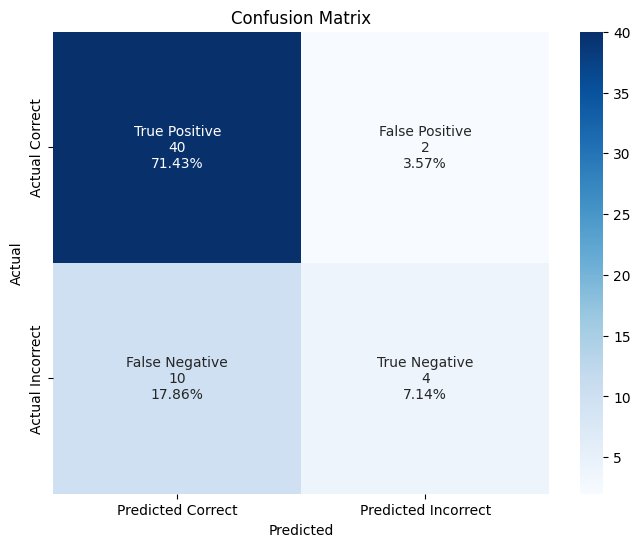

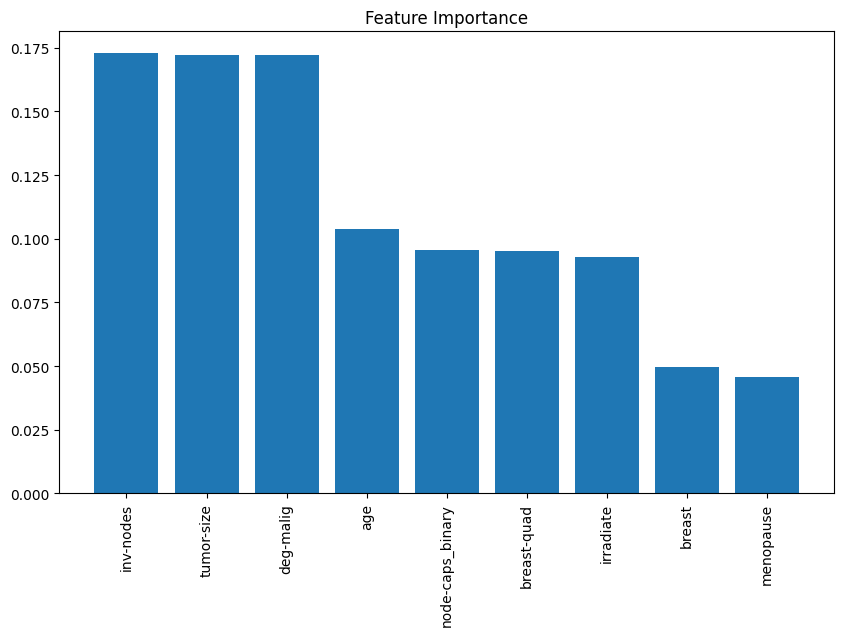

Cross-validation scores: [0.73214286 0.75       0.69090909 0.72727273 0.70909091]
Average cross-validation score: 0.7218831168831169


In [ ]:
!pip install scikit-learn==1.3.0

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder


# Separate features (X) and target (y)
X = df.drop('class_binary', axis=1)
y = df['class_binary']

# Convert object type columns to numerical using Label Encoding
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter optimization
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the model with the best parameters
best_rf_model = RandomForestClassifier(random_state=42, **best_params)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Using matplotlib and seaborn for better visualization
plt.figure(figsize=(8, 6))
group_names = ['True Positive', 'False Positive', 'False Negative', 'True Negative']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues",
            xticklabels=['Predicted Correct', 'Predicted Incorrect'],
            yticklabels=['Actual Correct', 'Actual Incorrect'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Feature Importance Plot
importances = best_rf_model.feature_importances_
feature_names = X.columns  # Assuming X is your DataFrame with feature names

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Create plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Cross-validation for more robust evaluation
scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='accuracy')  # You can change the scoring metric if needed
print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {scores.mean()}")



Random Forest (w/SMOTE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


ERROR: Operation cancelled by user
^C
Accuracy: 0.7857142857142857
Precision: 0.5833333333333334
Recall: 0.5
F1 Score: 0.5384615384615384


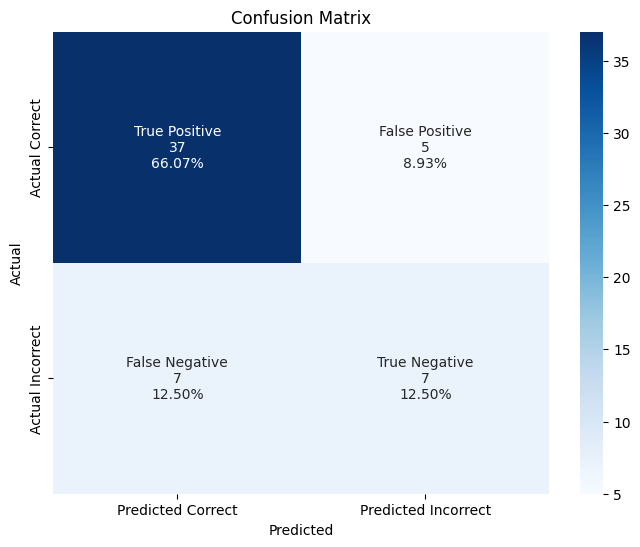

In [ ]:
!pip install imbalanced-learn==0.11.0
!pip install scikit-learn==1.3.0

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Assuming 'df' is your DataFrame
X = df.drop('class_binary', axis=1)
y = df['class_binary']

# Convert object type columns to numerical using Label Encoding
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)  # You can add hyperparameters here
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Using matplotlib and seaborn for better visualization
plt.figure(figsize=(8, 6))
group_names = ['True Positive', 'False Positive', 'False Negative', 'True Negative']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues",
            xticklabels=['Predicted Correct', 'Predicted Incorrect'],
            yticklabels=['Actual Correct', 'Actual Incorrect'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


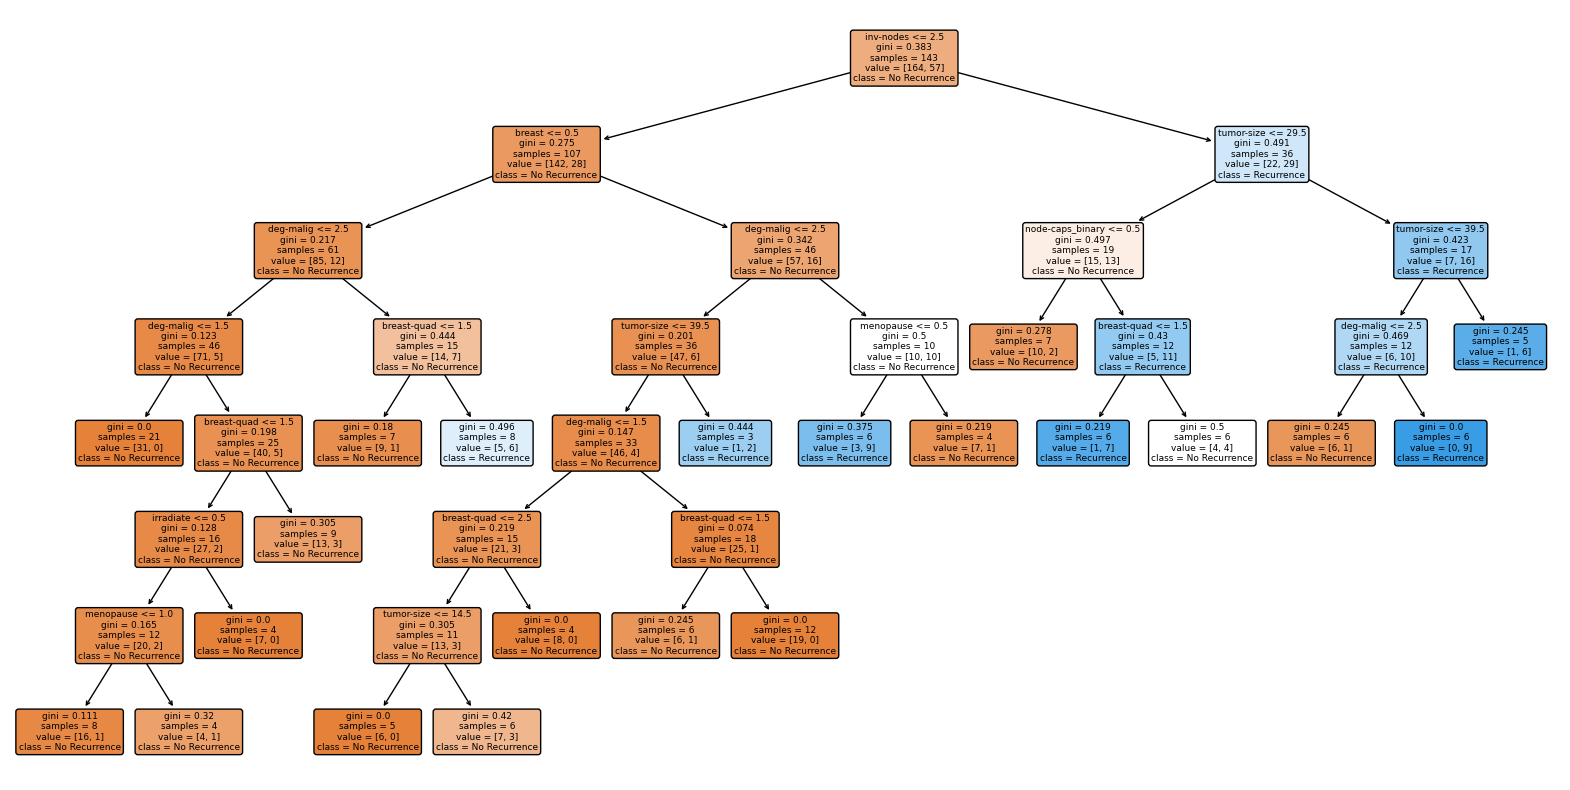

In [ ]:
# Visualize a single decision tree from the Random Forest
from sklearn.tree import plot_tree

# Extract a single tree from the forest (e.g., the first tree)
tree = best_rf_model.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 10))  # Adjust figure size as needed
# Convert X.columns (Pandas Index) to a Python list
plot_tree(tree, feature_names=list(X.columns), class_names=['No Recurrence', 'Recurrence'], filled=True, rounded=True)
plt.show()

Observations (Random Forest):
* SMOTE yields an improvement in recall and the F1 score but still could potentially be improved
* Accuracy (0.785 or 78.5%)
The model correctly classifies 78.5% of all instances in the dataset.
However, accuracy alone can be misleading, especially since the dataset is imbalanced (the no cancer recurrence appears much more than the other).
* Precision (0.666 or 66.6%)
Precision = TP / (TP + FP) (true positives divided by all predicted positives). 66.6% precision means that when the model predicts the positive class, it is correct 66.6% of the time.
A relatively low precision suggests many false positives (incorrectly classifying negatives as positives).
* Recall (0.286 or 28.6%)
Recall = TP / (TP + FN) (true positives divided by all actual positives). 28.6% recall means the model only identifies 28.6% of actual positive cases, missing a significant portion.
A low recall indicates the model has many false negatives (failing to detect positives).
* F1 Score (0.4 or 40%)
The F1 score is the harmonic mean of precision and recall, balancing both.
A low F1 score (40%) suggests the model is not performing well at detecting the positive class.

Cross-validation scores:

* Individual fold accuracies: 73.21%, 75%, 69.09%, 72.73%, 70.91%
Scores vary slightly, indicating stable performance across folds.
Average cross-validation score: 72.19%

* Shows consistent model performance on different data subsets.
Slightly lower than the test accuracy (78.57%), indicating potential overfitting.
Test accuracy: 78.57%

* Higher than the cross-validation average, suggesting some overfitting to the training data.

Feature Importance
* according to the random forest tree and feature importance bar chart, the most important features by decreasing importance are: inv-nodes, tumor-size, deg-malig, and age

#### Support Vector Machines (SVM)

Assumptions:
* It assumes data is independent and identically distributed


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.7242424242424242
Accuracy: 0.6785714285714286
Precision: 0.375
Recall: 0.42857142857142855
F1 Score: 0.4


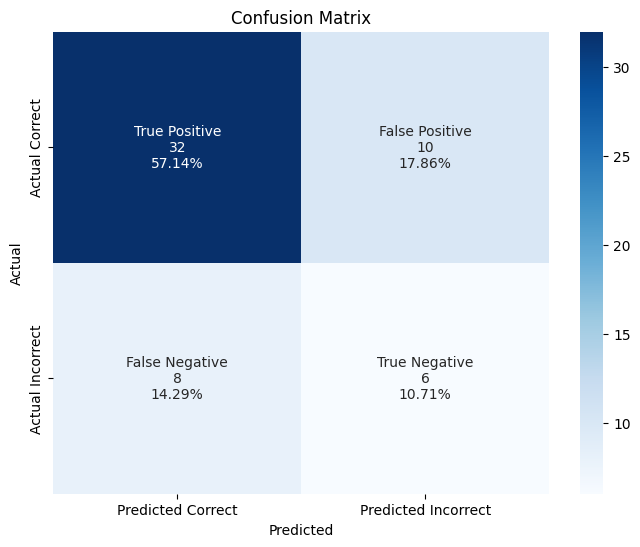

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
# Separate features (X) and target (y)
X = df.drop('class_binary', axis=1)
y = df['class_binary']

# Convert object type columns to numerical using Label Encoding
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter optimization
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear',], #only using linear kernel due to computational limits
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

# Create an SVM classifier
svm_classifier = SVC(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the model with the best parameters
best_svm_model = SVC(random_state=42, **best_params)
best_svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Using matplotlib and seaborn for better visualization
plt.figure(figsize=(8, 6))
group_names = ['True Positive', 'False Positive', 'False Negative', 'True Negative']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues",
            xticklabels=['Predicted Correct', 'Predicted Incorrect'],
            yticklabels=['Actual Correct', 'Actual Incorrect'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

SVM (w/SMOTE)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.6104177683765204
Accuracy: 0.5714285714285714
Precision: 0.2916666666666667
Recall: 0.5
F1 Score: 0.3684210526315789


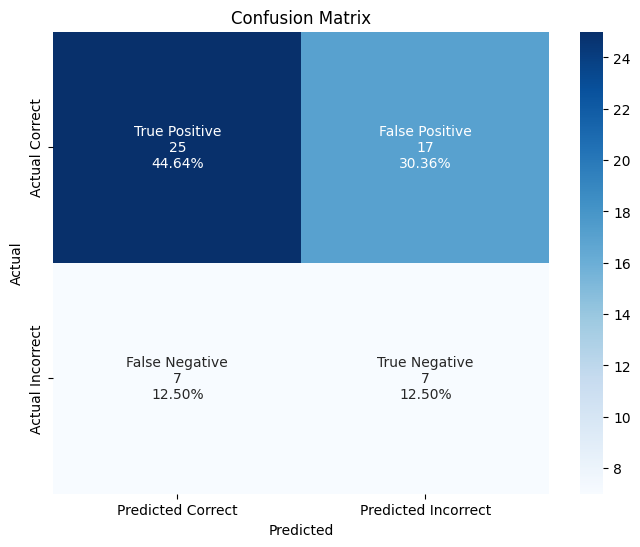

In [ ]:
!pip install imbalanced-learn==0.11.0

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Assuming 'df' is your DataFrame
X = df.drop('class_binary', axis=1)
y = df['class_binary']

# Convert object type columns to numerical using Label Encoding
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the parameter grid for hyperparameter optimization (adjust as needed)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear'],  # You can include other kernels if desired
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

# Create an SVM classifier
svm_classifier = SVC(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the model with the best parameters
best_svm_model = SVC(random_state=42, **best_params)
best_svm_model.fit(X_train_resampled, y_train_resampled)  # Use resampled data

# Make predictions on the test set
y_pred = best_svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Using matplotlib and seaborn for better visualization
plt.figure(figsize=(8, 6))
group_names = ['True Positive', 'False Positive', 'False Negative', 'True Negative']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt="", cmap="Blues",
            xticklabels=['Predicted Correct', 'Predicted Incorrect'],
            yticklabels=['Actual Correct', 'Actual Incorrect'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Observations (SVM):
* SMOTE leads to an improvement in recall but not an overall improvement in model performance
* Accuracy (0.679 or 67.9%)
The model correctly classifies 67.9% of all instances in the dataset.
However, accuracy alone can be misleading, especially since the dataset is imbalanced (the no cancer recurrence appears much more than the other).
* Precision (0.375 or 37.5%)
Precision = TP / (TP + FP) (true positives divided by all predicted positives). 37.5% precision means that when the model predicts the positive class, it is correct 66.6% of the time.
A relatively low precision suggests many false positives (incorrectly classifying negatives as positives).
* Recall (0.429 or 42.9%)
Recall = TP / (TP + FN) (true positives divided by all actual positives). 42.9% recall means the model only identifies 42.9% of actual positive cases, missing a significant portion.
A low recall indicates the model has many false negatives (failing to detect positives).
* F1 Score (0.4 or 40%)
The F1 score is the harmonic mean of precision and recall, balancing both.
A low F1 score (40%) suggests the model is not performing well at detecting the positive class.

#### Conclusion:
Among the three models evaluated (XGBoost, Random Forest, and SVM), XGBoost demonstrated the best overall performance in terms of accuracy (80.4%) and precision (71.4%). However, all models struggled with recall, indicating difficulty in correctly identifying actual cancer recurrence cases.

* XGBoost achieved the highest precision (71.4%) but had a low recall (35.7%), suggesting that while its positive predictions were relatively reliable, it missed a significant number of actual recurrence cases. The F1-score (47.6%) highlights this trade-off.
* Random Forest performed slightly worse in terms of accuracy (78.5%) and precision (66.6%) and had the lowest recall (28.6%), leading to an F1-score of 40%. Cross-validation results indicate some overfitting, with test accuracy (78.57%) exceeding the cross-validation average (72.19%).
* SVM had the lowest accuracy (67.9%), precision (37.5%), and F1-score (40%), but its recall (42.9%) was slightly better than the other models. This suggests it was somewhat better at identifying actual positive cases but generated too many false positives.

Key Takeaways:
* No model performed exceptionally well in recall, which is crucial for detecting cancer recurrence. A high number of false negatives could have severe consequences in a clinical setting.
* XGBoost was the best-performing model overall, balancing accuracy and precision, though it still struggled with recall.
* Random Forest showed some signs of overfitting, as indicated by the difference between cross-validation and test accuracy.
* SVM had the weakest performance across all metrics, making it the least favorable model for this task.